**GPU Setup**

In [1]:
import tensorflow as tf
import tf_utils

# Limit GPU memory growth
tf_utils.config_gpu_memory_usage()

 
2 Physical GPUs


In [2]:
# Choose the device to run on
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

Executing on device /job:localhost/replica:0/task:0/device:GPU:1 ...


**Other Imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sys

sys.path.append('/home/deveringham/thesis/rcwa_tf/src/')
import rcwa_utils
import tensor_utils
import solver
import solver_metasurface

In [4]:
gpu_memory_init = tf_utils.gpu_memory_info()

**Loss Function Definition**

In [5]:
def focal_spot():

  # Global parameters dictionary.
  global params

  # Generate permittivity and permeability distributions.
  ER_t, UR_t = solver.generate_coupled_cylindrical_resonators(r_x_var, r_y_var, params)

  #print('batchsize: ' + str(params['batchSize']))
  #print('pixelsX: ' + str(params['pixelsX']))
  #print('pixelsY: ' + str(params['pixelsY']))
  #print('Nlay: ' + str(params['Nlay']))
  #print('Nx: ' + str(params['Nx']))
  #print('Ny: ' + str(params['Ny']))
  #print('ER_t shape: ' + str(ER_t.shape) + '\n')

  # Simulate the system.
  outputs = solver.simulate(ER_t, UR_t, params)
  field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
  focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
  index = (params['pixelsX'] * params['upsample']) // 2
  f1 = tf.abs(focal_plane[0, index, index])

  # Maximize the electric field magnitude at the desired focal spot.
  return -f1

**Setup and Initialize Variables**

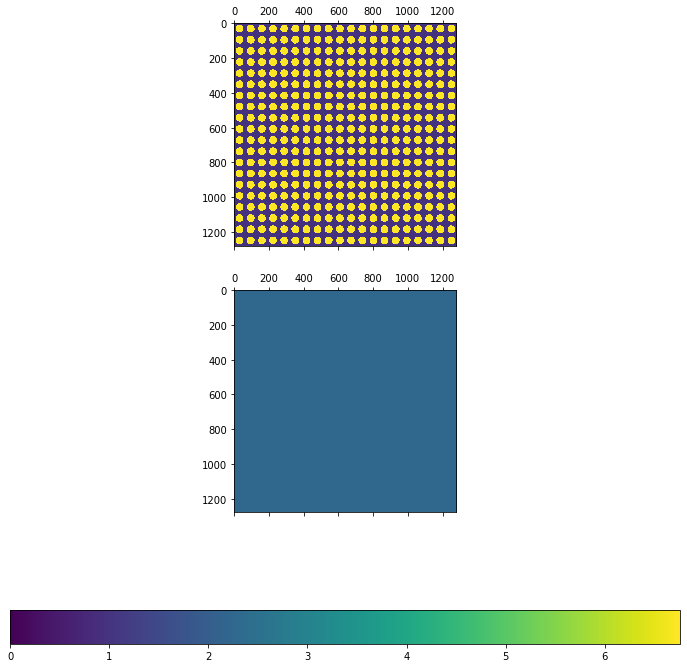

In [6]:
with tf.device(tfDevice):
    
    # Initialize global params dictionary.
    nPixels = 10
    params = solver.initialize_params(wavelengths = [632.0],
                          thetas = [0.0],
                          phis = [0.0],
                          pte = [1.0],
                          ptm = [0.0],
                          pixelsX = nPixels,
                          pixelsY = nPixels)
    params['erd'] = 6.76 # Grating layer permittivity.
    params['ers'] = 2.25 # Subtrate layer permittivity.
    params['PQ'] = [5, 5] # Fourier Harmonics.
    params['Nx'] = 128
    params['Ny'] = params['Nx']
    params['upsample'] = 11
    params['f'] = 1.0 * params['Lx'] * params['pixelsX']

    # Define the free-space propagator and input field distribution for the metasurface.
    params['propagator'] = solver.make_propagator(params, params['f'])
    params['input'] = solver.define_input_fields(params)

    # Define duty cycles for unit cells based on 4 coupled elliptical nanoposts.
    var_shape = (1, params['pixelsX'], params['pixelsY'], 4)
    r_x_initial = 0.175 * np.ones(shape = var_shape)
    r_y_initial = r_x_initial
    r_x_var = tf.Variable(r_x_initial, dtype = tf.float32)
    r_y_var = tf.Variable(r_y_initial, dtype = tf.float32)

    ER_t, UR_t = solver.generate_coupled_cylindrical_resonators(r_x_var, r_y_var, params)
    solver_metasurface.display_metasurface(ER_t, params)

**Optimize**

In [7]:
with tf.device(tfDevice):
    
    # Number of optimization iterations.
    N = 10

    # Define an optimizer and data to be stored.
    opt = tf.keras.optimizers.Adam(learning_rate = 2E-4)
    loss = np.zeros(N + 1)

    # Compute initial loss and duty cycle.
    loss[0] = focal_spot().numpy()
    print('Loss: ' + str(loss[0]))
    print('\nOptimizing...')

    # Optimize.
    for i in range(N):
        
        # Debug using GradientTape
        with tf.GradientTape() as tape:
            
            opt.minimize(focal_spot, var_list = [r_x_var, r_y_var])
            l = focal_spot()
            loss[i + 1] = l.numpy()
            print('Iteration ' + str(i))
            print('Loss: ' + str(loss[i+1]))
            #print('Gradient of loss wrt r_x: '  + str( tape.gradient(l, r_x_var) ))

Loss: -0.5171679258346558

Optimizing...


ResourceExhaustedError: OOM when allocating tensor with shape[1,10,10,2,1,367] and type complex64 on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc [Op:SplitV] name: split

**Display Learning Curve**

In [ ]:
with tf.device(tfDevice):
    
    plt.plot(loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(0, N)
    plt.show()

**Calculate the Focal Plane Intensity of the Optimized Structure**

In [ ]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver.generate_coupled_cylindrical_resonators(r_x_var, r_y_var, params)
    outputs = solver.simulate(ER_t, UR_t, params)
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

**Display Final Metasurface Shape**

In [ ]:
with tf.device(tfDevice):
    
    solver_metasurface.display_metasurface(ER_t, params)

In [ ]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))